In [ ]:
import math
import random
import numpy

In [1300]:
class Value:
    def __init__(self, data=1, children=[], _backward=lambda: None):
        self.data = data
        self.children = children
        self._backward = _backward
        self.grad = 0

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other))

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        
        return out
    
    def relu(self):
        out = Value(0.1*self.data if self.data < 0 else self.data, children=[self])

        def _backward():
            self.grad += (1 if out.data > 0 else 0.1) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        def _backward():
            self.grad += (1 - pow(out.data, 2)) * out.grad
        out = Value(math.tanh(self.data), children=[self], _backward=_backward)
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other))

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (float, int))

        def _backward():
            self.grad += other * self.data ** (other-1)
        out = Value(self.data**other, children=[self], _backward=_backward)
        return out
    
    def __repr__(self):
        return f'data: {self.data}'
    
    def backward(self):
        topo = []
        visited = set()

        def visit(node):
            if node not in visited:
                visited.add(node)
                for children in node.children:
                    visit(children)
                topo.append(node)

        self.grad = 1
        visit(self)
        for item in reversed(topo):
            item._backward()

    def __sub__(self, other):
            return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

In [1337]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
        
    
    def parameters(self):
        return []
    

class Neuron(Module):

    def __init__(self, nin, nonlinear=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlinear = nonlinear

    def __call__(self, x):
        out = sum([wi*xi for xi, wi in zip(x, self.w)], self.b)
        return out.tanh() if self.nonlinear else out
    
    def parameters(self):
        return self.w + [self.b]


class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP(Module):
    def __init__(self, nin, nouts):
        layers = [nin] + nouts
        self.layers = [Layer(layers[i], layers[i+1], nonlinear=(i!=len(nouts)-1)) for i in range(len(layers)-1)]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for neuron in layer.neurons for p in neuron.parameters()]
    
    def equation(self):
        val = ''
        layerEquations = []

        for layer in self.layers:

            neuronEquations = []
            for neuron in layer.neurons:

                equation = ''
                if len(layerEquations) == 0:

                    for w in neuron.w:
                        equation += f'{w.data:.2f}X + '

                else:
                    for w in neuron.w:
                        equation += f'{w.data:.2f}({layerEquations[-1]}) + '

                if neuron.nonlinear:
                    neuronEquations.append(f'tanh({equation}) + {neuron.b.data} + ')
                else:
                    neuronEquations.append(f'{equation}{neuron.b.data} + ')

            fullLayerEquation = ''

            for neuronEquation in neuronEquations:
                fullLayerEquation += neuronEquation

            layerEquations.append(fullLayerEquation)

        for layerEquation in layerEquations:
            val += layerEquation
        
        return val.replace(' + )', '').replace(' + ,', '')[:-3]


In [1338]:
model = MLP(1, [100, 20, 1])

In [1339]:
import torch

In [1366]:

X = numpy.array([random.uniform(-5, 5) for _ in range(100)])

Y = numpy.sin(X)

In [1369]:
for _ in range(800):
    idx = numpy.random.randint(0, X.shape, (1,))

    out = model(X[idx])

    expected = Y[idx]

    out = (out-expected)**2

    print(out.data)

    out.backward()

    for p in model.parameters():
        p.data -= p.grad * 0.000001
        p.grad = 0

[0.04872911]
[0.03857881]
[0.10905323]
[0.02943739]
[0.02541662]
[0.00811403]
[0.04911059]
[0.05825756]
[0.01527582]
[0.13353967]
[0.00409306]
[0.03414339]
[0.06821091]
[0.02648315]
[0.14491786]
[0.01254721]
[0.04912088]
[0.01898706]
[0.0704886]
[0.05828229]
[0.00847409]
[0.00031207]
[0.01773524]
[0.02334562]
[0.00491481]
[0.10249443]
[0.06208371]
[0.01086032]
[0.04358252]
[0.03147706]
[0.13304355]
[0.04701663]
[0.01917595]
[0.00613985]
[0.01124156]
[0.07050017]
[0.00845083]
[0.00022186]
[0.03148691]
[0.03148371]
[0.15578359]
[0.02942796]
[0.13234629]
[0.03279215]
[0.03235381]
[0.00015525]
[0.03850602]
[0.01554809]
[0.01256374]
[0.00303905]
[0.07039757]
[0.04778701]
[0.00217169]
[0.00166462]
[0.00078276]
[0.08825465]
[0.136309]
[0.0294092]
[0.04738984]
[0.01894865]
[0.00585152]
[0.0155561]
[0.00052924]
[0.02530021]
[0.01525747]
[0.00166194]
[0.1330081]
[0.14518212]
[0.01891413]
[0.14516067]
[0.06168759]
[0.00241565]
[0.00650986]
[0.14513634]
[0.00141824]
[0.01527062]
[0.03274296]
[0.01

In [1357]:
idx = numpy.random.randint(0, X.shape, (1,))
print(f'output: {model([X[idx]])} vs. expected: {Y[idx]}')

output: data: [1.03143061] vs. expected: [0.99998679]


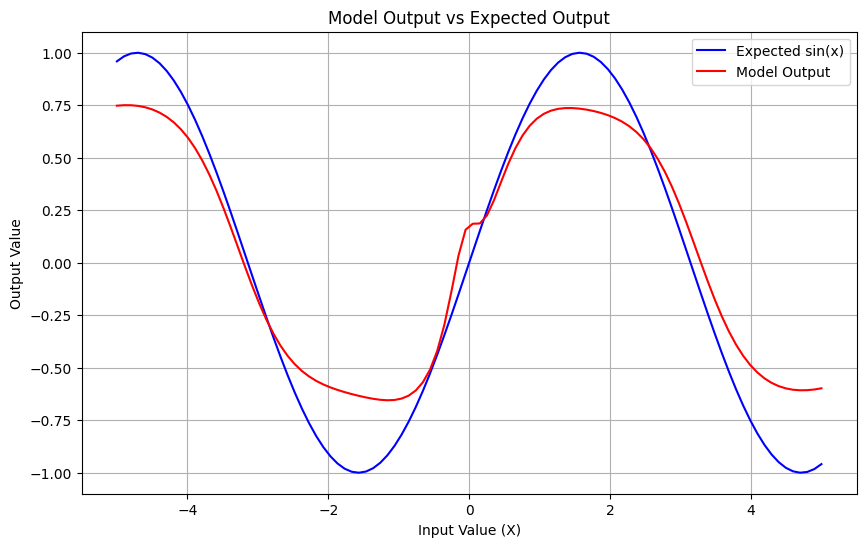

In [1370]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-5, 5, 100)

Y = numpy.sin(X)

model_predictions = [model([x]).data for x in X]

plt.figure(figsize=(10,6))
plt.plot(X, Y, label='Expected sin(x)', color='blue')
plt.plot(X, model_predictions, label='Model Output', color='red')
plt.title('Model Output vs Expected Output')
plt.xlabel('Input Value (X)')
plt.ylabel('Output Value')
plt.legend()
plt.grid(True)
plt.show()